In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load data

In [107]:
data = pd.read_csv('Solver verification experiment.csv')
other_data = pd.read_csv('Solver verification experiment_other-data.csv')

print(f"Main data shape: {data.shape}")
data.head()

Main data shape: (3000, 11)


,wins,wins_without_guess,time_elapsed,samples_considered,samples_with_solutions,difficulty,sample_size,use_num_mines_constraint,first_click_pos,first_click_is_zero,parameters_id
0,48,46,1.999817,159,155,Beginner (9x9),11x11,True,"(3, 3)",True,1
1,48,48,2.109485,162,160,Beginner (9x9),11x11,True,"(3, 3)",True,1
2,47,46,2.234476,168,163,Beginner (9x9),11x11,True,"(3, 3)",True,1
3,49,45,2.265723,155,149,Beginner (9x9),11x11,True,"(3, 3)",True,1
4,47,44,2.468828,163,156,Beginner (9x9),11x11,True,"(3, 3)",True,1


In [108]:
print(f"Other data shape: {other_data.shape}")
other_data

Other data shape: (1, 8)


,sample_size,use_num_mines_constraint,first_click_pos,num_games,verbose,visualise,agent_seed,run_seed
0,NaN,True,"(3, 3)",50000,False,False,20,2020


# Analyse

In [109]:
# Group by parameters combo and sum up columns of interest
data_sum = data.groupby(['parameters_id'], as_index=False).agg({
    'difficulty': 'first',
    'wins': 'sum',
    'wins_without_guess' : 'sum',
    'time_elapsed' : 'sum',
    'samples_considered' : 'sum',
    'samples_with_solutions' : 'sum',
    })

# Remove id column as the difficulty it represents is enough info and has already been included
data_sum = data_sum.drop('parameters_id', axis=1)

In [110]:
# Calculate win rates and insert into new columns
num_games = other_data['num_games'][0]
data_sum['win rate (%)'] = data_sum['wins'] / num_games * 100
data_sum['win rate without guess (%)'] = data_sum['wins_without_guess'] / num_games * 100

In [114]:
#~92% Beginner ~72% Intermediate ~16% Expert
data_sum['external_solver_data'] = False
data_sum = data_sum.append([
    {'difficulty': 'Beginner (9x9)', 'external_solver_data' : True, 'win rate without guess (%)' : 92},
    {'difficulty': 'Intermediate (16x16)', 'external_solver_data' : True, 'win rate without guess (%)' : 72},
    {'difficulty': 'Expert (16x30)', 'external_solver_data' : True, 'win rate without guess (%)' : 16}
], ignore_index=True)

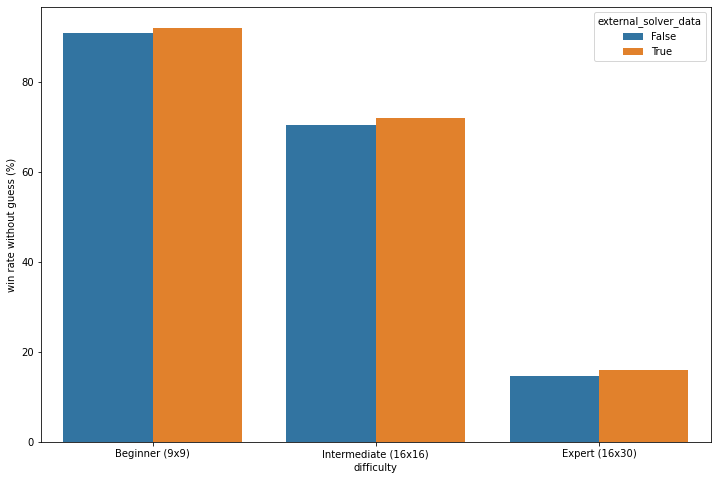

In [115]:
sns.barplot(x='difficulty', y='win rate without guess (%)', hue='external_solver_data', data=data_sum)
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.show()

In [207]:
# Print difference from expected win rates (actual - expected) for each difficulty
current = data_sum[data_sum['external_solver_data'] == False]
external = data_sum[data_sum['external_solver_data'] == True]

for i in current.index:
    row = current.iloc[i]
    matching_external_row = external[external['difficulty'] == row.difficulty].iloc[0]
    win_rate_diff = row['win rate without guess (%)'] - matching_external_row['win rate without guess (%)']
    win_rate_diff = round(win_rate_diff, 2)
    print(f"{row.difficulty}: {win_rate_diff}%")

Beginner (9x9): -1.18%
Intermediate (16x16): -1.64%
Expert (16x30): -1.43%


In [208]:
# Get cumulative sum for wins
data_cum_sums = pd.DataFrame(data.groupby('difficulty')[['wins', 'wins_without_guess']].cumsum())

# Append column showing how many games have been played overall for each row (50 games per row that
# shows up in-order for that difficulty)
data_cum_sums['num_games'] = 50 * (data.groupby('difficulty').cumcount() + 1)

# Append difficulty column
data_cum_sums['difficulty'] = data['difficulty']

data_cum_sums

,wins,wins_without_guess,num_games,difficulty
0,48,46,50,Beginner (9x9)
1,96,94,100,Beginner (9x9)
2,143,140,150,Beginner (9x9)
3,192,185,200,Beginner (9x9)
4,239,229,250,Beginner (9x9)
...,...,...,...,...
2995,18015,7254,49800,Expert (16x30)
2996,18031,7261,49850,Expert (16x30)
2997,18044,7266,49900,Expert (16x30)
2998,18067,7271,49950,Expert (16x30)


In [213]:
# Calculate win rates and insert into new columns
data_cum_sums['win rate (%)'] = round(data_cum_sums['wins'] / data_cum_sums['num_games'] * 100, 2)
data_cum_sums['win rate without guess (%)'] = round(data_cum_sums['wins_without_guess'] / data_cum_sums['num_games'] * 100, 2)

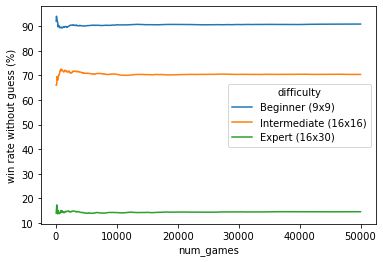

In [214]:
sns.lineplot(x='num_games', y='win rate without guess (%)', hue='difficulty', data=data_cum_sums)
plt.show()

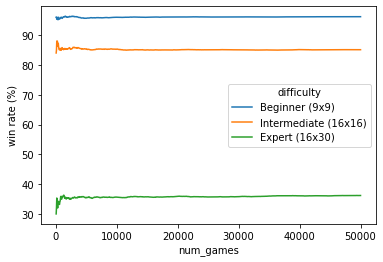

In [215]:
sns.lineplot(x='num_games', y='win rate (%)', hue='difficulty', data=data_cum_sums)
plt.show()

In [220]:
x = data_cum_sums['win rate (%)'].iloc[-1]
x

36.18

In [252]:
y = ((data_cum_sums[data_cum_sums.difficulty == 'Expert (16x30)']['win rate (%)'] - x))
y[100:]

2100   -0.75
2101   -0.71
2102   -0.67
2103   -0.60
2104   -0.64
        ... 
2995   -0.01
2996   -0.01
2997   -0.02
2998   -0.01
2999    0.00
Name: win rate (%), Length: 900, dtype: float64

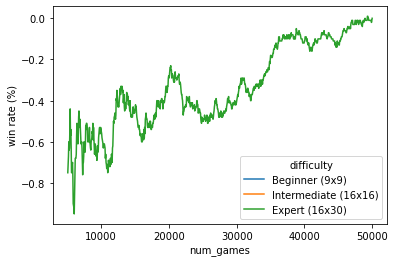

In [254]:
sns.lineplot(x='num_games', y=y[100:], hue='difficulty', data=data_cum_sums[100:])
plt.show()